## RNN with attention

Классический алгоритм генерации последовательность с помощью рекуррентных слоев и механизмом внимания.

In [1]:
import sys
sys.path.append('src/')
import numpy as np
import matplotlib.pyplot as plt

from models.rnn import MusicRNN
from preprocess import parse_files_to_sequences, limit_uniq_notes, get_dictionaries
from save_midi import save_notes_and_durations

In [2]:
folderpath = "tabs/"
track_name = 'guitar'

In [3]:
notes, durations = parse_files_to_sequences(folderpath, track_name)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
notes, durations = limit_uniq_notes(notes, durations, 150)

In [5]:
note_dictionary, inv_note_dictionary, notes_to_int, \
duration_dictionary, inv_dur_dictionary, durations_to_int = get_dictionaries(notes, durations)

In [6]:
RNN = MusicRNN(
    n_notes=len(note_dictionary),
    n_durations=len(duration_dictionary),
    emb_size=64,
    n_units=128,
    n_layers=2,
    use_dropout=True,
    use_attention=True,
)

In [7]:
RNN.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     9600        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     2048        input_2[0][0]                    
______________________________________________________________________________________________

In [8]:
seq_length = 128
step = 1
X, y = RNN.prepare_sequences(notes_to_int, durations_to_int, seq_length, step)

In [9]:
RNN.model.fit(
    X, y,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/30
387/387 [==============================] - 43s 105ms/step - loss: 5.4564 - dense_1_loss: 4.0240 - dense_2_loss: 1.4324 - val_loss: 5.7846 - val_dense_1_loss: 4.3572 - val_dense_2_loss: 1.4274
Epoch 2/30
387/387 [==============================] - 39s 101ms/step - loss: 4.6658 - dense_1_loss: 3.4954 - dense_2_loss: 1.1704 - val_loss: 5.8502 - val_dense_1_loss: 4.4283 - val_dense_2_loss: 1.4219
Epoch 3/30
387/387 [==============================] - 40s 102ms/step - loss: 4.2725 - dense_1_loss: 3.1939 - dense_2_loss: 1.0786 - val_loss: 6.0714 - val_dense_1_loss: 4.5683 - val_dense_2_loss: 1.5031
Epoch 4/30
387/387 [==============================] - 39s 101ms/step - loss: 4.0154 - dense_1_loss: 2.9730 - dense_2_loss: 1.0424 - val_loss: 6.1326 - val_dense_1_loss: 4.5618 - val_dense_2_loss: 1.5708
Epoch 5/30
387/387 [==============================] - 39s 100ms/step - loss: 3.8100 - dense_1_loss: 2.8122 - dense_2_loss: 0.9979 - val_loss: 6.1735 - val_dense_1_loss: 4.6390 - val_dense_

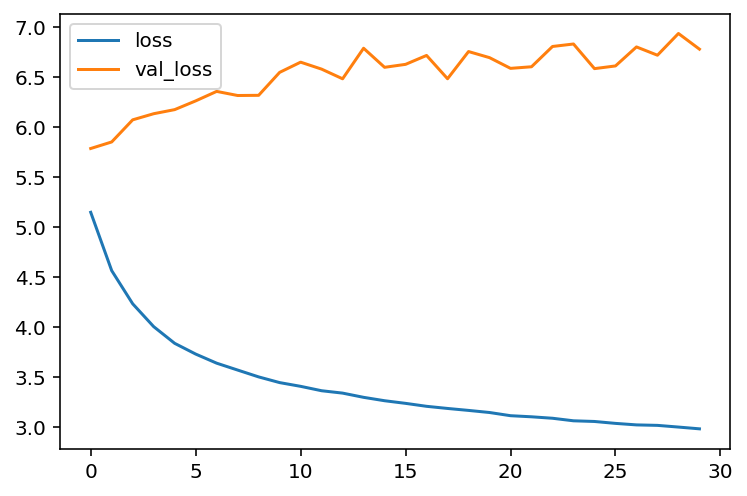

In [10]:
plt.figure()
plt.plot(RNN.model.history.history['loss'], label='loss')
plt.plot(RNN.model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [11]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [16]:
len(notes_to_int)

15599

In [17]:
temperatures = [0.0, 0.5, 0.9]
n_generated = 128

# att_matrix = np.zeros((n_generated+seq_length, n_generated))

for temperature in temperatures:
    generated = [notes_to_int[15000:15128], durations_to_int[15000:15128]]
    for i in range(n_generated):
        note_pred, duration_pred = RNN.model.predict([np.array(generated[0][i:]), np.array(generated[1][i:])])
        generated[0].append(sample(note_pred[0], temperature))
        generated[1].append(sample(duration_pred[0], temperature))
    #     if use_attention:
    #         att_preds = RNN.att_model.predict(generated[i:])[0]
    #         att_matrix[(i-len(att_preds)+seq_length):(i+seq_length), i] = att_preds
    
    generated = [[inv_note_dictionary[x] for x in generated[0]], [inv_dur_dictionary[x] for x in generated[1]]]
    save_notes_and_durations(generated, f'output/rnn/output_{temperature}')

In [16]:
# if use_attention:
#     fig, ax = plt.subplots(figsize=(20,20))
#     im = ax.imshow(att_matrix[(seq_length-2):,], cmap='coolwarm', interpolation='nearest')
#     ax.set_xticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.set_yticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
#     ax.set_xticks(np.arange(len(generated_to_notes) - seq_length))
#     ax.set_yticks(np.arange(len(generated_to_notes)- seq_length+2))
#     ax.set_xticklabels([n for n in generated_to_notes[(seq_length):]])
#     ax.set_yticklabels([n for n in generated_to_notes[(seq_length - 2):]])
#     ax.xaxis.tick_top()    
#     plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
#              rotation_mode="anchor")

#     plt.show()